In [1]:
from math import pi
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime
now=datetime.datetime.now

## Generate data

$f(x_1,x_2)=0.5\sin(\pi x)\sin(\pi x_2)+0.8\cos^2(\pi x_1)+0.3\sin(\pi x_2)$

In [2]:
coef=pi
def my_objective(X):
    Y=0.5*np.sin(coef*X[:,0])*np.sin(coef*X[:,1])+0.8*np.cos(coef*X[:,0])**2+0.3*np.sin(coef*X[:,1])
    return Y

In [3]:
np.random.seed(0)
m=10
X1,X2=np.meshgrid(np.linspace(-0.95,0.95,m),np.linspace(-0.95,0.95,m))

In [4]:
print(X1.shape)
print(X2.shape)

(10, 10)
(10, 10)


In [5]:
X1_flatten=X1.flatten()
X2_flatten=X2.flatten()

In [6]:
print(X1_flatten.shape)
print(X2_flatten.shape)

(100,)
(100,)


In [7]:
X=np.concatenate((X1_flatten.reshape(-1,1), X2_flatten.reshape(-1,1)), axis=1)
print(X.shape)

(100, 2)


In [8]:
Y=my_objective(X)

In [9]:
print(X.shape)
print(Y.shape)

(100, 2)
(100,)


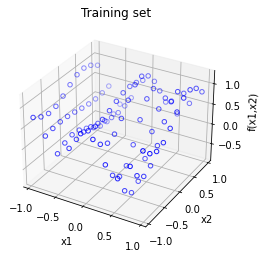

In [10]:
# plot data
fig = plt.figure()
ax=plt.axes(projection='3d')
ax.scatter(X[:,0],X[:,1],Y,facecolors='none', edgecolors='b')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x1,x2)')
plt.title('Training set')
plt.savefig('2_mesh_target.png')
plt.show()

## Set Device

In [11]:
num_qubits=3
dev=qml.device('default.qubit', wires=num_qubits)

## Define embedding layer

In [12]:
# define my own embedding layer
def myembedding(x,wires):
    qml.RY(coef*x[0], wires=wires[1])
    qml.RY(coef*x[1], wires=wires[2])

## Define the Hamiltonian matrix transformation layer

In [13]:
def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

## Define ansatze

In [14]:
# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubit 0
    qml.RX(theta[0,0],wires=0)
    qml.RZ(theta[0,1],wires=0)
    qml.RX(theta[0,2],wires=0)
    
    # rotations on qubit 1
    qml.RX(theta[1,0],wires=1)
    qml.RZ(theta[1,1],wires=1)
    qml.RX(theta[1,2],wires=1)
    
    # rotations on qubit 2
    qml.RX(theta[2,0],wires=2)
    qml.RZ(theta[2,1],wires=2)
    qml.RX(theta[2,2],wires=2)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[0, 2])

In [15]:
@qml.qnode(dev)
def quantum_net(theta,x):
    
    # encode data
    myembedding(x,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # print(v)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(2))

In [16]:
num_layers=4
num_rotations=3
theta=np.random.uniform(0,2*pi,size=(num_layers,num_qubits,num_rotations),requires_grad=True)
print(theta.shape)
print(theta)

(4, 3, 3)
[[[3.44829694 4.49366732 3.78727399]
  [3.42360201 2.66190161 4.0582724 ]
  [2.74944154 5.60317502 6.0548717 ]]

 [[2.40923412 4.97455513 3.32314479]
  [3.56912924 5.8156952  0.44633272]
  [0.54744954 0.12703594 5.23150478]]

 [[4.88930306 5.46644755 6.14884039]
  [5.02126135 2.89956035 4.90420945]
  [0.74314013 4.02074236 0.90071527]]

 [[5.93552986 3.27886971 2.60539781]
  [1.66225193 4.86465374 2.86607707]
  [3.57157584 0.1180598  3.88071828]]]


In [17]:
quantum_net(theta,[0,0])

tensor([ 0.31895404, -0.19977291], requires_grad=True)

In [18]:
print(qml.draw(quantum_net)(theta,[0,0]))

0: ──H─────────RX(3.45)──RZ(4.49)──RX(3.79)─╭●────╭●──H─────────RX(2.41)──RZ(4.97)──RX(3.32)─╭●───
1: ──RY(0.00)──RX(3.42)──RZ(2.66)──RX(4.06)─╰X─╭●─│───RX(3.57)──RZ(5.82)──RX(0.45)───────────╰X─╭●
2: ──RY(0.00)──RX(2.75)──RZ(5.60)──RX(6.05)────╰X─╰X──RX(0.55)──RZ(0.13)──RX(5.23)──────────────╰X

──╭●──H─────────RX(4.89)──RZ(5.47)──RX(6.15)─╭●────╭●──H─────────RX(5.94)──RZ(3.28)──RX(2.61)─╭●───
──│───RX(5.02)──RZ(2.90)──RX(4.90)───────────╰X─╭●─│───RX(1.66)──RZ(4.86)──RX(2.87)───────────╰X─╭●
──╰X──RX(0.74)──RZ(4.02)──RX(0.90)──────────────╰X─╰X──RX(3.57)──RZ(0.12)──RX(3.88)──────────────╰X

──╭●──H─┤  <Z>
──│─────┤     
──╰X────┤  <Z>


## Add classical layer

In [19]:
# add the classical layer
def classical_quantum_net(theta,w,x):
    r1=quantum_net(theta,x)[0]
    r2=quantum_net(theta,x)[1]
    return w[0]+w[1]*r1+w[2]*r1**2+w[3]*r2+w[4]*r2**2

In [20]:
def square_loss(labels,predictions):
    loss=0
    for l,p in zip(labels,predictions):
        loss=loss+(l-p)**2
    loss=loss/len(labels)
    return loss

In [21]:
def cost(theta,w,features,labels):
    preds=[classical_quantum_net(theta,w,x) for x in features]
    return square_loss(labels,preds)

## Model training
Using the Adam optimizer, we update the weights for 200 steps (this takes some time). More steps will lead to a better fit.

In [22]:
w=np.zeros(5,requires_grad=True)
opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

In [23]:
start=now()
print(start)

2022-08-07 11:30:18.773794


In [24]:
epochs=200
for e in range(1,epochs+1):
    
    (theta,w,_,_),_cost=opt.step_and_cost(cost,theta,w,X,Y)

    if e==1 or e%10==0:
        print(f'Epoch: {e} | Cost: {_cost} | w: {w}')

Epoch: 1 | Cost: 0.361325602805173 | w: [0.04999998 0.04999964 0.04999949 0.0499999  0.04999989]
Epoch: 10 | Cost: 0.14527468657198397 | w: [0.3488489  0.2509224  0.33224621 0.35963655 0.40035665]
Epoch: 20 | Cost: 0.11603281712078471 | w: [0.32795648 0.23759047 0.36046713 0.48351846 0.49220735]
Epoch: 30 | Cost: 0.09711510958348243 | w: [0.25809917 0.33138047 0.3605255  0.72689577 0.42699681]
Epoch: 40 | Cost: 0.07268863025027254 | w: [0.21640441 0.51168957 0.41768925 0.91757403 0.38684239]
Epoch: 50 | Cost: 0.051505018259325894 | w: [0.13626717 0.58937608 0.64251613 1.12698153 0.39981567]
Epoch: 60 | Cost: 0.023148603479990197 | w: [0.0742582  0.49582169 1.11734653 1.36198091 0.48473736]
Epoch: 70 | Cost: 0.003690216256973245 | w: [0.04452571 0.35444051 1.6191925  1.56165484 0.5831603 ]
Epoch: 80 | Cost: 0.0010010121816668026 | w: [0.02619797 0.30299204 1.91633325 1.67638158 0.60831585]
Epoch: 90 | Cost: 0.0014414335475110302 | w: [0.01953568 0.30736181 2.04180463 1.71984965 0.596062

In [25]:
pred_train=np.array([classical_quantum_net(theta,w,x) for x in X])

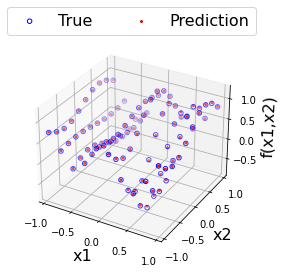

In [26]:
fig = plt.figure()
ax=plt.axes(projection='3d')
ax.scatter(X[:,0],X[:,1],Y,facecolors='none', edgecolors='b', label='True')
ax.scatter(X[:,0],X[:,1],pred_train, color='red',marker="x",s=4,label='Prediction')
ax.set_xlabel('x1',fontsize=16)
ax.set_ylabel('x2',fontsize=16)
ax.set_zlabel('f(x1,x2)',fontsize=16)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
plt.savefig('2_mesh_train.png')
plt.show()

In [27]:
train_diff=np.abs(Y-pred_train)

In [28]:
np.max(train_diff)

tensor(0.0377774, requires_grad=True)

In [29]:
np.min(train_diff)

tensor(4.45836867e-06, requires_grad=True)

In [30]:
np.mean(train_diff)

tensor(0.00820777, requires_grad=True)

## Test error

In [31]:
test1,test2=np.meshgrid(np.linspace(-0.95,0.95,100),np.linspace(-0.95,0.95,100))
test1_flatten=test1.flatten()
test2_flatten=test2.flatten()
X_test=np.concatenate((test1_flatten.reshape(-1,1), test2_flatten.reshape(-1,1)), axis=1)
Y_test=my_objective(X_test)
print(X_test.shape)
print(Y_test.shape)
pred_test=[classical_quantum_net(theta,w,x) for x in zip(test1_flatten,test2_flatten)]

(10000, 2)
(10000,)


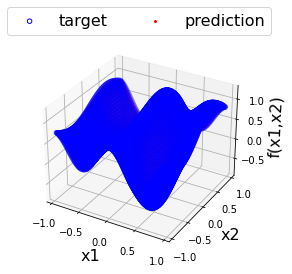

In [32]:
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter(X_test[:,0],X_test[:,1],Y_test,facecolors='none', edgecolors='b',label='target')
ax.scatter(X_test[:,0],X_test[:,1],pred_test,color='red',marker="x",s=4,label='prediction')
ax.set_xlabel('x1',fontsize=16)
ax.set_ylabel('x2',fontsize=16)
ax.set_zlabel('f(x1,x2)',fontsize=16)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
plt.savefig('2_mesh_test.png')
plt.show()

In [33]:
test_diff=np.abs(Y_test-pred_test)

In [34]:
np.max(test_diff)

tensor(0.03844948, requires_grad=True)

In [35]:
np.min(test_diff)

tensor(2.30867024e-07, requires_grad=True)

In [36]:
np.mean(test_diff)

tensor(0.00859514, requires_grad=True)